In [8]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import stats
import sqlite3
pd.set_option('display.max_rows', 500)

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [9]:
DB = "hockey_dataMVP.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

In [10]:
#import data
goalie_data = pd.read_csv('advancedgoaliestats.csv')
# teamtraining.drop(columns=['Unnamed: 0','t1_wins','t1_loses','t1_ties','t1_otl',
#                            't1_points','t1_total_games','t1_recent_wins', 't1_recent_loses', 't1_recent_ties',
#                            't1_recent_otl','t1_recent_points','t2_wins','t2_loses','t2_ties','t2_otl',
#                            't2_points','t2_total_games','t2_recent_wins', 't2_recent_loses', 't2_recent_ties',
#                            't2_recent_otl','t2_recent_points'],axis=1,inplace=True)

# #randomly pull test/training set (reserve 20% for test)
# mask = np.random.rand(teamtraining.shape[0]) < 0.8

# teamtrain = teamtraining[mask]
# teamtrain = teamtrain.dropna(axis = 0)
# teamtest = teamtraining[~mask]
# teamtest = teamtest.dropna(axis = 0)

In [11]:
goalie_data

,Unnamed: 0,player_id,team_id,opp_id,date_game,age,rest_days,min_season,shots_against,save_pct,min3W,sa3W,svepct3W,future_save_pct,injured,team_srs,opp_srs
0,0,aebisda01,COL,CAR,2001-01-06,22.915,11,562.250000,218,0.904,117.483333,45,0.866667,0.905000,0,0.762703,-0.465261
1,1,aebisda01,COL,CHI,2001-01-14,22.937,8,627.250000,239,0.904,123.333333,46,0.869565,0.913000,0,0.774097,-0.059206
2,2,aebisda01,COL,MDA,2001-01-21,22.956,7,692.250000,262,0.905,130.000000,44,0.909091,0.889000,0,0.878412,-0.592877
3,3,aebisda01,COL,NSH,2001-01-27,22.973,6,752.250000,280,0.904,125.000000,41,0.902439,0.889000,0,0.920343,-0.150104
4,4,aebisda01,COL,VAN,2001-02-01,22.986,5,811.583333,289,0.903,184.333333,50,0.900000,0.905915,0,1.007099,0.320772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182,366,bironma01,NYR,CAR,2012-03-01,34.545,6,922.750000,383,0.911,122.666667,49,0.857143,0.913000,0,0.670530,-0.370590
4183,367,bironma01,NYR,OTT,2012-03-08,34.564,7,982.616667,406,0.911,124.866667,50,0.900000,0.857000,0,0.610407,0.102901
4184,368,bironma01,NYR,CAR,2012-03-13,34.578,5,1041.116667,427,0.909,183.366667,71,0.887324,0.931000,0,0.537043,-0.383010
4185,369,bironma01,NYR,PIT,2012-03-15,34.584,2,1101.116667,456,0.910,243.366667,100,0.900000,0.844000,0,0.556967,0.624373


<h2>First look at Correlations</h2>

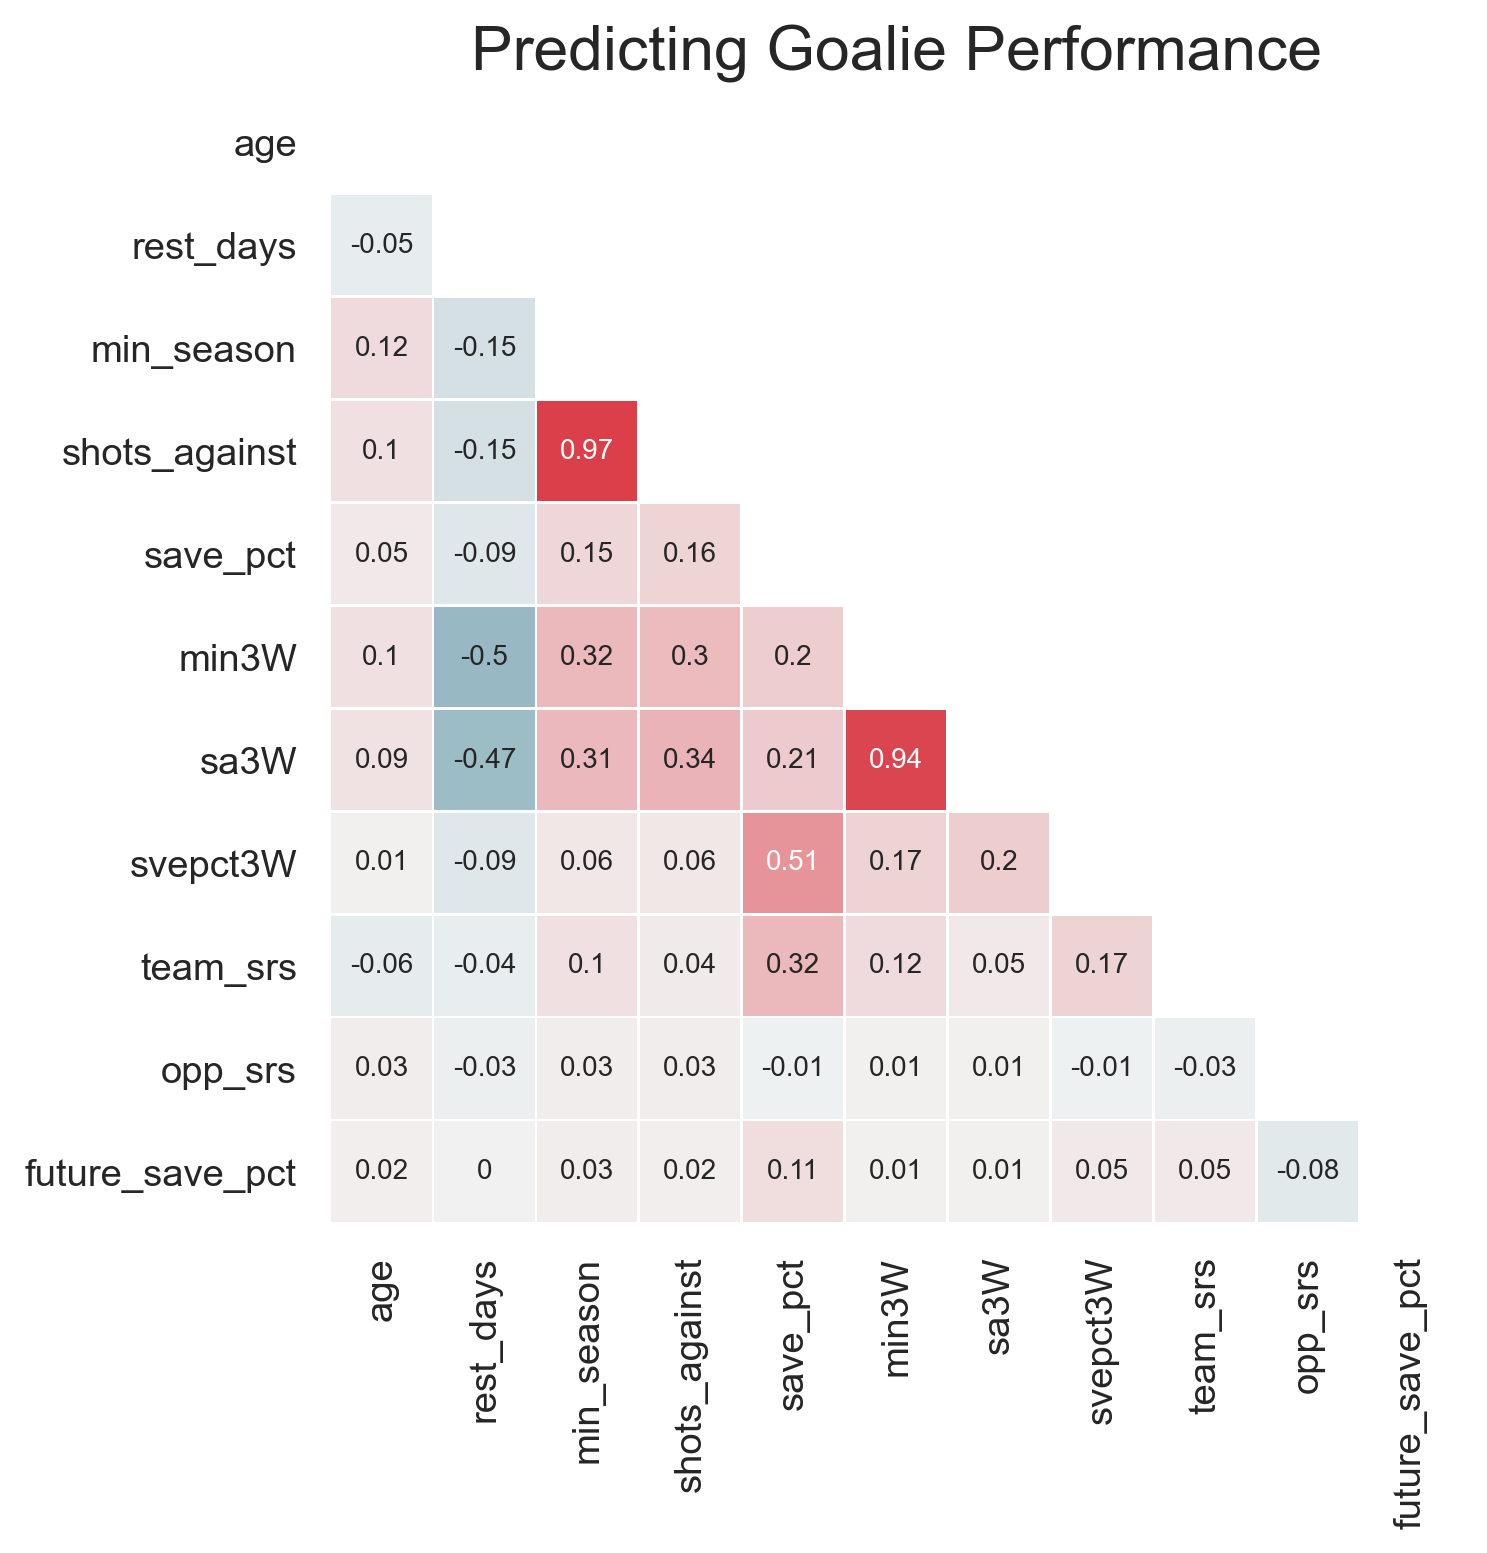

In [12]:
#add test data back for EDA
fig4 = plt.figure(figsize=(12,6),dpi=250)
sns.set(font_scale=1)
corr1 = np.round(goalie_data[['age','rest_days','min_season','shots_against','save_pct','min3W','sa3W','svepct3W','team_srs','opp_srs','future_save_pct']].corr(),2)
# Generate a mask for the upper triangle
npmask1 = np.triu(np.ones_like(goalie_data[['age','rest_days','min_season','shots_against','save_pct','min3W','sa3W','svepct3W','team_srs','opp_srs','future_save_pct']].corr(), dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1,mask=npmask1,annot=True,annot_kws={"size": 8},square=True,cmap=cmap,vmax=1, center=0,linewidths=.5,  cbar=False)
plt.title('Predicting Goalie Performance',fontsize=18)
plt.gca().set_facecolor('white')

In [13]:
goalie_data =pd.read_csv('goalietrainingdata.txt')
goalie_data[400:450]

,Unnamed: 0,player_id,team_id,opp_id,date_game,age,rest_days,min_season,shots_against,save_pct,min3W,sa3W,svepct3W,future_save_pct,injured
400,193,allenja01,STL,WPG,2018-02-09,27.510,3,2138.333333,1079,0.909,150.583333,89,0.921348,0.909,0
401,194,allenja01,STL,PIT,2018-02-11,27.515,2,2198.266667,1101,0.909,157.866667,79,0.911392,0.864,0
402,195,allenja01,STL,DAL,2018-02-16,27.529,5,2257.883333,1123,0.908,217.483333,101,0.900990,0.875,0
403,196,allenja01,STL,WPG,2018-02-23,27.548,7,2316.283333,1139,0.908,217.950000,72,0.861111,0.826,0
404,197,allenja01,STL,NSH,2018-02-25,27.553,2,2376.150000,1162,0.906,277.816667,95,0.852632,0.897,0
405,198,allenja01,STL,MIN,2018-02-27,27.559,2,2436.066667,1201,0.906,297.733333,122,0.877049,0.625,0
406,199,allenja01,STL,SJS,2018-03-08,27.584,9,2456.066667,1209,0.904,198.183333,86,0.848837,0.971,0
407,200,allenja01,STL,LAK,2018-03-10,27.589,2,2514.783333,1244,0.906,198.500000,105,0.885714,0.950,0
408,201,allenja01,STL,ANA,2018-03-12,27.595,2,2574.783333,1284,0.907,258.500000,145,0.903448,0.909,0
409,202,allenja01,STL,COL,2018-03-15,27.603,3,2634.783333,1306,0.907,318.500000,167,0.904192,0.864,0


In [14]:
goalie_data =pd.read_csv('goalietrainingdata.txt')
goalie_data.drop(columns=['Unnamed: 0'],inplace=True)
#track previous injuries
goalie_data['pre_inj'] = 0
goalie_list = goalie_data['player_id'].unique()
for player in goalie_list:

    goalie_career = goalie_data[goalie_data['player_id']==player].copy().reset_index(drop=True)

    #track any previous injuries
    for i in range(1,goalie_career.shape[0]):
        goalie_career.loc[i,'pre_inj'] = goalie_career.loc[i-1,'pre_inj'] + goalie_career.loc[i-1,'injured']
    print(player,goalie_career['pre_inj'].sum())    
    goalie_data.loc[goalie_data['player_id']==player,'pre_inj'] = np.array(goalie_career['pre_inj'])

aebisda01 0
allenja01 388
andercr01 4178
anderfr01 2406
aubinje01 0
auldal01 12
bacasja01 26
bachmri01 10
backsni01 1922
bailesc01 0
balesmi01 0
barrato01 2092
beaupdo01 687
beaurst01 0
belfoed01 1317
bergeje01 0
bernijo01 1462
berrare01 40
berthda01 0
berubje02 0
besteal01 0
bierkza01 1
billicr01 729
binnijo01 0
bironma01 105
bishobe01 2710
blackda01 0
blackma01 76
bluejo01 0
bobrose01 2592
bouchbr01 309
brathfr01 0
brodema01 2654
brossla01 19
brustba01 0
bryzgil01 1117
budajpe01 4
burkese01 3383
campbja01 0
careyji01 0
caronse01 19
caseyjo01 0
cassifr01 0
cechmro01 6
chabofr01 0
charpse01 0
cheveti01 0
clemmsc01 72
cloutda01 174
cloutja01 0
dafoeby01 40
danisya01 0
darlisc01 56
delguma01 0
deliaco01 0
dellaa01 0
demkoth01 0
denisma01 434
desmica01 0
desropa01 0
dipieri01 1529
divisre01 0
dominlo01 96
drapeto01 0
driedch01 4
drouije01 0
dubiewa01 0
dubnyde01 1834
dunhami01 413
elliobr01 975
ellisda01 243
emeryra01 871
enrotjh01 70
ersbeer01 39
eschero01 116
essenbo01 0
fankhsc01 0
fas

In [15]:
np.random.seed(34)
#get random sample
no_injury = goalie_data[goalie_data['injured']==0].iloc[np.random.randint(0,50000,830),:]
injury = goalie_data[goalie_data['injured']==1]
cols = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
for c in cols:
    print(c,stats.ttest_ind(no_injury[c],injury[c]))

age Ttest_indResult(statistic=-3.9886126688780745, pvalue=6.935298030645032e-05)
min_season Ttest_indResult(statistic=2.113153657443765, pvalue=0.03473669182900286)
rest_days Ttest_indResult(statistic=0.9825787177118639, pvalue=0.3259581789547543)
shots_against Ttest_indResult(statistic=1.3506199434500856, pvalue=0.17700151481286525)
save_pct Ttest_indResult(statistic=-1.4143284175280633, pvalue=0.1574532500318193)
min3W Ttest_indResult(statistic=0.6942696609162596, pvalue=0.4876103790386508)
sa3W Ttest_indResult(statistic=-0.5385588364616779, pvalue=0.590263592325853)
svepct3W Ttest_indResult(statistic=-0.8009628584235932, pvalue=0.42326790950057036)
pre_inj Ttest_indResult(statistic=-12.716139407781275, pvalue=2.045440279510188e-35)


<h2>Create Training Data</h2>

In [16]:
data = goalie_data[goalie_data['injured']==0].iloc[np.random.randint(0,50000,2000),:]
data = data.append(goalie_data[goalie_data['injured']==1])
mask = (np.random.rand(data.shape[0]) < 0.8)
train = data[mask].sample(frac=1)
test = data[~mask].sample(frac=1)

In [17]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate as CV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import pickle

In [18]:
num_pipeline = Pipeline([('std_scaler',StandardScaler())])
columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
trainX = num_pipeline.fit_transform(train[columns])
trainY = np.array(train['injured'])
testX = num_pipeline.fit_transform(test[columns])
testY = np.array(test['injured'])
logR = RandomForestClassifier()
logR.fit(trainX,trainY)

predicted = ran_for.predict(trainX)
true_positives = np.sum((predicted==1)&(trainY==1))
false_positives = np.sum((predicted==1)&(trainY==0))
true_negatives = np.sum((predicted==0)&(trainY==0))
false_negatives = np.sum((predicted==0)&(trainY==1))

print("Precision is %0.2f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))

NameError: name 'ran_for' is not defined

In [ ]:
predicted = logR.predict(testX)
predicted.sum()

In [ ]:
true_positives = np.sum((predicted==1)&(testY==1))
false_positives = np.sum((predicted==1)&(testY==0))
true_negatives = np.sum((predicted==0)&(testY==0))
false_negatives = np.sum((predicted==0)&(testY==1))

print("Precision is %0.2f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))

<h2>Try on all the data</h2>

In [ ]:
b = 1
data = goalie_data[goalie_data['injured']==0].iloc[np.random.randint(0,50000,b*goalie_data[goalie_data['injured']==1].shape[0]),:]
data = data.append(goalie_data[goalie_data['injured']==1])
mask = (np.random.rand(data.shape[0]) < 0.8)
train = data[mask].sample(frac=1)
test = data[~mask].sample(frac=1)
num_pipeline = Pipeline([('std_scaler',StandardScaler())])
columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
trainX = num_pipeline.fit_transform(train[columns])
trainY = np.array(train['injured'])
testX = num_pipeline.fit_transform(test[columns])
testY = np.array(test['injured'])
logistic = LogisticRegression()
logistic.fit(trainX,trainY)
ypred = logistic.predict(testX)
yreal = testY
tp = ((ypred==1)&(yreal==1)).sum()
fp = ((ypred==1)&(yreal==0)).sum()
fn = ((ypred==0)&(yreal==1)).sum()
print("Test Data:Identified %s injuries of %s with a precision of %0.2f and recall of %0.2f"%(tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn)))


gd = goalie_data.sample(frac=1)
ypred = logistic.predict(num_pipeline.fit_transform(gd[columns]))
yreal = np.array(gd['injured'])
tp = ((ypred==1)&(yreal==1)).sum()
fp = ((ypred==1)&(yreal==0)).sum()
fn = ((ypred==0)&(yreal==1)).sum()
print("Trial %d:Identified %s injuries of %s with a precision of %0.2f and recall of %0.2f"%(b,tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn)))


In [ ]:
fpr,tpr,thresholds = roc_curve(np.array(gd['injured']),
                               logistic.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,"b--",label="LogisticRegression: AUC=%0.3f"%(roc_auc_score(np.array(gd['injured']),logistic.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1])))
#plt.plot(thresholds,recall[:-1],"g-",label="recall")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for ALL The Data',font='Garamond',fontsize=32,pad = 15)
plt.savefig('ROCforAlltheData.png')
plt.show()

In [ ]:
lr = LogisticRegression()
ytrain_p = cross_val_predict(lr,trainX,trainY,cv=5)

from sklearn.metrics import confusion_matrix
confusion_matrix(trainY,ytrain_p)

In [ ]:
ypred = logistic.predict_proba(num_pipeline.fit_transform(gd[columns]))
yreal = np.array(gd['injured'])

In [ ]:
m = .5
tp = ((ypred[:,1]>=m)&(yreal==1)).sum()
fp = ((ypred[:,1]>=m)&(yreal==0)).sum()
fn = ((ypred[:,1]<=m)&(yreal==1)).sum()

print("Trial %d:Identified %s injuries of %s with a precision of %0.2f and recall of %0.2f"%(b,tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn)))

In [ ]:
(gd['injured']==1).sum()/gd.shape[0]

In [ ]:
for i in range(10):
    rg = np.random.random(gd.shape[0])
    tp = ((rg<.0127)&(gd['injured']==1)).sum()
    fp = ((rg<.0127)&(gd['injured']==0)).sum()
    fn = ((rg>.0127)&(gd['injured']==1)).sum()
    print("Trial %d:Identified %s injuries of %s with a precision of %0.2f and recall of %0.2f"%(b,tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn)))

In [ ]:
from joblib import dump, load
dump(logistic, 'logistic_regression.joblib')

In [ ]:
lrm = load('logistic_regression.joblib') 

In [ ]:
ypred = lrm.predict_proba(num_pipeline.fit_transform(gd[columns]))
yreal = np.array(gd['injured'])

In [ ]:
m = .8
tp = ((ypred[:,1]>=m)&(yreal==1)).sum()
fp = ((ypred[:,1]>=m)&(yreal==0)).sum()
fn = ((ypred[:,1]<=m)&(yreal==1)).sum()

print("Trial %d:Identified %s injuries of %s with a precision of %0.2f and recall of %0.2f"%(b,tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn)))

<h2>Random Forest</h2>

In [21]:
b = 1
data = goalie_data[goalie_data['injured']==0].iloc[np.random.randint(0,50000,b*goalie_data[goalie_data['injured']==1].shape[0]),:]
data = data.append(goalie_data[goalie_data['injured']==1])
mask = (np.random.rand(data.shape[0]) < 0.8)
train = data[mask].sample(frac=1)
test = data[~mask].sample(frac=1)
num_pipeline = Pipeline([('std_scaler',StandardScaler())])
columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
trainX = num_pipeline.fit_transform(train[columns])
trainY = np.array(train['injured'])
testX = num_pipeline.fit_transform(test[columns])
testY = np.array(test['injured'])
ran_for = RandomForestClassifier()
ran_for.fit(trainX,trainY)
ypred = ran_for.predict(testX)
yreal = testY
tp = ((ypred==1)&(yreal==1)).sum()
fp = ((ypred==1)&(yreal==0)).sum()
fn = ((ypred==0)&(yreal==1)).sum()

print("Test Data:Identified %s injuries of %s with a precision of %0.2f and recall of %0.2f"%(tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn)))


gd = goalie_data.sample(frac=1)
ypred = ran_for.predict(num_pipeline.fit_transform(gd[columns]))
yreal = np.array(gd['injured'])
tp = ((ypred==1)&(yreal==1)).sum()
fp = ((ypred==1)&(yreal==0)).sum()
fn = ((ypred==0)&(yreal==1)).sum()
print("Trial %d:Identified %s injuries of %s with a precision of %0.2f and recall of %0.2f"%(b,tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn)))

Test Data:Identified 101 injuries of 167 with a precision of 0.63 and recall of 0.60
Trial 1:Identified 745 injuries of 830 with a precision of 0.02 and recall of 0.90


In [ ]:
cross_val_score(ran_for,trainX,trainY,cv=5,scoring='roc_auc')

In [ ]:
ypred = ran_for.predict_proba(num_pipeline.fit_transform(gd[columns]))
for i in range(0,10,1):
    cm = confusion_matrix(np.array(gd['injured']),ypred[:,1]>i/10)
    print(i,(cm[1,1]/(cm[0,1]+cm[1,1]))/.0127)

In [22]:
from joblib import dump, load
dump(ran_for, 'ranforest_regression.joblib')

['ranforest_regression.joblib']

In [23]:
dump(num_pipeline, 'pipeline.joblib')

['pipeline.joblib']